Dorian Gailhard & Paul Grangette

In [4]:
import numpy as np
import scipy.stats as sp
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
#Gaussian processes
#1)
def kernel(theta,x_i,x_j):
    return theta[0]*np.exp(-theta[1]/2*(x_i-x_j)@(x_i-x_j)) + theta[2] + theta[3]*x_i@x_j

def C(X,theta):
    n = X.shape[0]
    c = np.array([[kernel(theta,X[i],X[j]) for j in range(n)] for i in range(n)])
    
    c += theta[4]*np.eye(n)

    return c

#Gradient descent with barrier method to keep theta positive
def training(Y,X,n_iter,learning_rate):
    n = X.shape[0]
    p = X.shape[1]
    
    theta = np.random.random(size=5)
    
    loglike = np.zeros(n_iter)
    
    for k in range(n_iter):
        #Kernel matrix
        C_N = C(X,theta)
        C_N_inv = np.linalg.inv(C_N)
        
        #Derivative of the kernel matrix
        dC_N_dtheta = np.zeros((5,n,n))
        dC_N_dtheta[0] = np.array([[np.exp(-theta[1]/2*(X[i] - X[j])@(X[i] - X[j])) for j in range(n)] for i in range(n)])
        dC_N_dtheta[1] = np.array([[-1/2*(X[i] - X[j])@(X[i] - X[j]) * theta[0] * np.exp(-theta[1]/2*(X[i] - X[j])@(X[i] - X[j])) for j in range(n)] for i in range(n)])
        dC_N_dtheta[2] = np.ones((n,n))
        dC_N_dtheta[3] = np.array([[X[i]@X[j] for j in range(n)] for i in range(n)])
        dC_N_dtheta[4] = np.eye(n)
        
        #Computing the step
        step = np.array([-1/2*np.trace(C_N_inv@dC_N_dtheta[i]) + 1/2*Y@(C_N_inv@dC_N_dtheta[i]@C_N_inv@Y) for i in range(5)])
        step /= np.linalg.norm(step) #To stabilize the descent
        
        #Updating theta
        theta += learning_rate[k] * step
        
        loglike[k] = -1/2*np.log(np.linalg.det(C_N)) - 1/2*Y@(C_N_inv@Y) - n/2*np.log(2*np.pi)

    C_N = C(X,theta)
    C_N_inv = np.linalg.inv(C_N)
    return theta, C_N, C_N_inv, loglike

In [15]:
#2)
def pred(x_new,X,Y,C_,C_inv,theta_):
    n = X.shape[0]
    
    #Computing of k
    k = np.array([kernel(theta_,X[i],x_new) for i in range(n)])
    
    #Computing of c
    c = kernel(theta,x_new,x_new) + theta_[4]
    
    #Prediction
    m = k@(C_inv@Y)
    sigma2 = c - k@(C_inv@k)
    
    return sp.norm(loc=m,scale=np.sqrt(sigma2))

In [16]:
data = pd.read_csv("UScrimes.csv")

print(data)

        Unnamed: 0  Murder  Assault  UrbanPop
0          Alabama    13.2      236        58
1           Alaska    10.0      263        48
2          Arizona     8.1      294        80
3         Arkansas     8.8      190        50
4       California     9.0      276        91
5         Colorado     7.9      204        78
6      Connecticut     3.3      110        77
7         Delaware     5.9      238        72
8          Florida    15.4      335        80
9          Georgia    17.4      211        60
10          Hawaii     5.3       46        83
11           Idaho     2.6      120        54
12        Illinois    10.4      249        83
13         Indiana     7.2      113        65
14            Iowa     2.2       56        57
15          Kansas     6.0      115        66
16        Kentucky     9.7      109        52
17       Louisiana    15.4      249        66
18           Maine     2.1       83        51
19        Maryland    11.3      300        67
20   Massachusetts     4.4      14

In [17]:
#Training
n_samples = data.shape[0]

data_training = data[["Murder","Assault","UrbanPop"]].to_numpy()[0:int(n_samples*3/4)]

X_training = data_training[:,1:3]
Y_training = data_training[:,0]

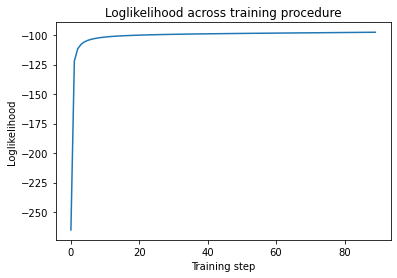

[2.62448764 0.2317864  0.89271073 0.17785628 2.59929735]


In [75]:
n_iter = 90
learning_rate = np.array([1/(k+1)**1.2 for k in range(90)])

theta, C_matrix, C_inv, loglike = training(Y_training,X_training,n_iter,learning_rate)

plt.plot(np.arange(0,n_iter),loglike)
plt.xlabel("Training step")
plt.ylabel("Loglikelihood")
plt.title("Loglikelihood across training procedure")
plt.show()

print(theta)

In [76]:
#Test
data_test = data[["Murder","Assault","UrbanPop"]].to_numpy()[int(n_samples*3/4)+1:n_samples]

X_test = data_test[:,1:3]
Y_test = data_test[:,0]

Y_pred = np.array([pred(x,X_training,Y_training,C_matrix,C_inv,theta).mean() for x in X_test])

RMSE = np.linalg.norm((Y_test-Y_pred)/np.sqrt(Y_test.shape[0]))

In [77]:
#Multivariate linear model
X = X_training

w = np.linalg.inv(X.T@X)@X.T@Y_training

Y_pred_linear = X_test@w

RMSE_linear = np.linalg.norm((Y_test-Y_pred_linear)/np.sqrt(Y_pred_linear.shape[0]))

#Multivariate affine model
X = np.hstack((X_training,np.ones((X_training.shape[0],1))))

w = np.linalg.inv(X.T@X)@X.T@Y_training

Y_pred_affine = X_test@w[0:-1] + w[-1]

RMSE_affine = np.linalg.norm((Y_test-Y_pred_affine)/np.sqrt(Y_pred_affine.shape[0]))

In [78]:
print("The RMSE obtained with Gaussian Processes is %f"%RMSE)
print("The RMSE obtained with Multivariate Linear Model is %f"%RMSE_linear)
print("The RMSE obtained with Multivariate Affine Model is %f"%RMSE_affine)

The RMSE obtained with Gaussian Processes is 2.566516
The RMSE obtained with Multivariate Linear Model is 2.595638
The RMSE obtained with Multivariate Affine Model is 2.422705


The Gaussian Processes regression performs slightly better than the Linear regression but worse than the affine model.